In [1]:
import math 

import numpy as np
from numpy import asarray
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from torch.autograd import Variable
import torchvision
import matplotlib
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
from autograd_lib import autograd_lib
import torch.nn.functional as F     # Contains all the functions in the torch.nn library


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [4]:
def train(inputDataLoader,model,loss_function,optimizer,epochNumber):
    
    model.train()
    acccs=[]
    loss_array=[]
    for (inputs,label) in inputDataLoader:
        label=label.to(device)
        inputs = inputs.reshape(-1, 28*28).to(device)
        output=model.forward(inputs)
        loss=loss_function(output,label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        # measure accuracy and record loss
        acc1 = accuracy(preds, labels)
        acccs.append(acc1)
    return np.mean(loss_array)

In [5]:
def test(inputDataLoader,model,loss_function,optimizer):
    model.eval()
    output_result=[]
    loss_result=[]
    acccs=[]

    with torch.no_grad():
        for (inputs,label) in inputDataLoader:
            inputs = inputs.reshape(-1, 28*28).to(device)
            label=label.to(device)
            output=model.forward(inputs)
            loss=loss_function(output,label)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            # measure accuracy and record loss
            acc1 = accuracy(preds, labels)
            acccs.append(acc1)


In [6]:
class NeuralNet(torch.nn.Module):

    def __init__(self):
        super(NeuralNet, self).__init__()
                 # 784 inputs, connects to hidden layer with 600 nodes
        self.fc1 = nn.Linear(in_features=784, out_features=600)
                   # 600 nodes connects to hidden layer with 500 nodes
        self.fc2 = nn.Linear(in_features=600, out_features=500) 
                   # 500 nodes connects to hidden layer with 250 nodes
        self.fc3 = nn.Linear(in_features=500, out_features=250) 
                   # connection between the last hidden layer 
                   # and the output layer (with 10 nodes)
        self.fc4 = nn.Linear(in_features=250, out_features=10)  
                                                                
    def forward(self, x):
        x = x.view(-1,784)          # Put all the entries of the image in the vector
        x = F.relu(self.fc1(x))     # Input x into first layer and apply a ReLU
        # to the nodes in this layer
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x 

In [7]:
def initMNIST(batch_size_train,batch_size_test):
    train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

    test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)
    return train_loader,test_loader

In [8]:
m1_train_loader,m1_test_loader=initMNIST(60000,10000)
print(len(m1_train_loader))

1


In [9]:
def linear_interpolation(alpha,theta_one,theta_two):
    return alpha*theta_two+(1-alpha)*theta_one

In [10]:
m1_train_loader,m1_test_loader=initMNIST(64,64)
m2_train_loader,m2_test_loader=initMNIST(1024,1024)
epochs=10
m1=NeuralNet()
m1.to(device)
criterion=nn.CrossEntropyLoss()
m1_optimizer=optim.Adam(m1.parameters(), lr = 1e-3)
m2=NeuralNet()
m2.to(device)
m2_optimizer=optim.Adam(m2.parameters(), lr = 1e-3)

In [11]:
for i in range(0,epochs,1):
    train(m1_train_loader,m1,criterion,m1_optimizer,i)
    test(m1_test_loader,m1,criterion,m1_optimizer)
torch.save(m1.state_dict(),"./model/m1")

/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
for i in range(0,epochs,1):
    train(m2_train_loader,m2,criterion,m2_optimizer,i)
    test(m2_test_loader,m2,criterion,m2_optimizer)
torch.save(m2.state_dict(),"model/m2")

In [13]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)
m1_new = torch.load('./model/m1')
m2_new = torch.load('./model/m2')
theta_one=Params2Vec(m1.parameters())
theta_two=Params2Vec(m2.parameters())


In [14]:
losses_test=[]
accuracy_test=[]
losses_train=[]
accuracy_train=[]

inferred_model_train_loader,inferred_model_test_loader=initMNIST(60000,10000)
for alpha in torch.arange(-2, 2, 0.1):
    infer_net=NeuralNet()
    Vec2Params(linear_interpolation(alpha,theta_one,theta_two),infer_net.parameters())
    infer_net.to(device)
    for data,label in inferred_model_train_loader:
        data=data.to(device)
        label=label.to(device)
        prediction_train=infer_net(data)
        loss_train=criterion(prediction_train,label).item()
        preds_train = np.argmax(prediction_train.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        acc1 = accuracy(preds_train, labels)
        losses_train.append(loss_train)
        accuracy_train.append(acc1)
    for data,label in inferred_model_test_loader:
        with torch.no_grad():
            infer_net.eval()
            data=data.to(device)
            label=label.to(device)
            prediction_test=infer_net(data)
            loss_test=criterion(prediction_test,label).item()
            preds_test = np.argmax(prediction_test.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            acc1 = accuracy(preds_test, labels)
            losses_test.append(loss_test)
            accuracy_test.append(acc1)
    
        

In [15]:
alpha=np.arange(-2.0, 2.0, 0.1)

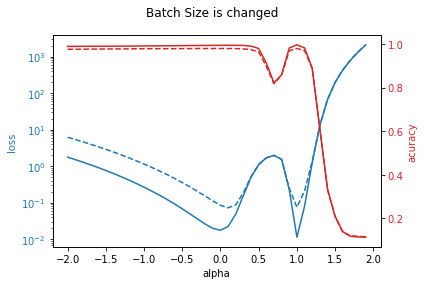

In [16]:
fig, ax1 = plt.subplots()
fig.suptitle("Batch Size is changed")
color = 'tab:blue'
ax1.set_xlabel('alpha')
ax1.set_yscale('log')

ax1.set_ylabel('loss', color=color)
ax1.plot(alpha, losses_train, color=color,label="train")
ax1.plot(alpha, losses_test, '--', color=color,label="test")

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('acuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(alpha, accuracy_train, color=color)
ax2.plot(alpha, accuracy_test, '--',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig("linear_1.png")

In [24]:
m1_train_loader,m1_test_loader=initMNIST(256,256)
m2_train_loader,m2_test_loader=initMNIST(256,256)
epochs=10
m1=NeuralNet()
m1.to(device)
criterion=nn.CrossEntropyLoss()
m1_optimizer=optim.Adam(m1.parameters(), lr = 1e-4)
m2=NeuralNet()
m2.to(device)
m2_optimizer=optim.Adam(m2.parameters(), lr = 1e-2)

In [25]:
for i in range(0,epochs,1):
    train(m1_train_loader,m1,criterion,m1_optimizer,i)
    test(m1_test_loader,m1,criterion,m1_optimizer)
torch.save(m1.state_dict(),"./model/m1.1")

/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/nkulshr/.conda/envs/DL/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [26]:
for i in range(0,epochs,1):
    train(m2_train_loader,m2,criterion,m2_optimizer,i)
    test(m2_test_loader,m2,criterion,m2_optimizer)
torch.save(m2.state_dict(),"model/m2.2")

In [27]:
from torch.nn.utils import (
  parameters_to_vector as Params2Vec,
  vector_to_parameters as Vec2Params
)
m1_new = torch.load('./model/m1.1')
m2_new = torch.load('./model/m2.2')
theta_one=Params2Vec(m1.parameters())
theta_two=Params2Vec(m2.parameters())


In [28]:
losses_test=[]
accuracy_test=[]
losses_train=[]
accuracy_train=[]

inferred_model_train_loader,inferred_model_test_loader=initMNIST(60000,10000)
for alpha in torch.arange(-2, 2, 0.1):
    infer_net=NeuralNet()
    Vec2Params(linear_interpolation(alpha,theta_one,theta_two),infer_net.parameters())
    infer_net.to(device)
    for data,label in inferred_model_train_loader:
        data=data.to(device)
        label=label.to(device)
        prediction_train=infer_net(data)
        loss_train=criterion(prediction_train,label).item()
        preds_train = np.argmax(prediction_train.detach().cpu().numpy(), axis=1)
        labels = label.detach().cpu().numpy()
        acc1 = accuracy(preds_train, labels)
        losses_train.append(loss_train)
        accuracy_train.append(acc1)
    for data,label in inferred_model_test_loader:
        with torch.no_grad():
            infer_net.eval()
            data=data.to(device)
            label=label.to(device)
            prediction_test=infer_net(data)
            loss_test=criterion(prediction_test,label).item()
            preds_test = np.argmax(prediction_test.detach().cpu().numpy(), axis=1)
            labels = label.detach().cpu().numpy()
            acc1 = accuracy(preds_test, labels)
            losses_test.append(loss_test)
            accuracy_test.append(acc1)
    
        

In [29]:
alpha=np.arange(-2.0, 2.0, 0.1)

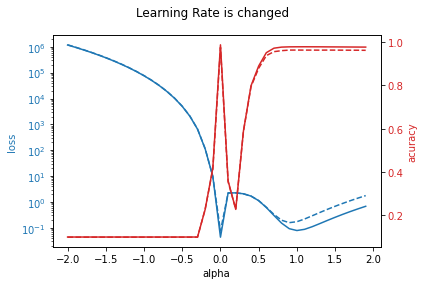

In [30]:
fig, ax1 = plt.subplots()
fig.suptitle("Learning Rate is changed")

color = 'tab:blue'
ax1.set_xlabel('alpha')
ax1.set_yscale('log')

ax1.set_ylabel('loss', color=color)
ax1.plot(alpha, losses_train, color=color,label="train")
ax1.plot(alpha, losses_test, '--', color=color,label="test")

ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('acuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(alpha, accuracy_train, color=color)
ax2.plot(alpha, accuracy_test, '--',color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig("linear_2.png")